In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.integrate import simpson


In [2]:
def NPtoquad(RealA22,ImA22,RealA21,ImA21,RealA20,ImA20,RealA2minus1,ImA2minus1,RealA2minus2,ImA2minus2):
    c = 2.99792458e10
    G = 6.6743e-8
    kpc2cm = 3.0856769e+21

    o=np.zeros_like(ImA20)

    if (np.array_equal(RealA22, RealA2minus2) and
    np.array_equal(ImA22, -ImA2minus2) and
    np.array_equal(ImA20, o) and
    np.array_equal(RealA21, -RealA2minus1) and
    np.array_equal(ImA21, ImA2minus1)):

        m1 = np.sqrt(32 * np.pi / (15)) * (G / (c ** 4)) * (1 / 10 * kpc2cm)
        m2 = np.sqrt(16 * np.pi / (5)) * (G / (c ** 4)) * (1 / 10 * kpc2cm)
        m3 = np.sqrt(4 * np.pi / (5)) * (G / (c ** 4)) * (1 / 10 * kpc2cm)

        I11 = RealA22 / (2 * m3) - RealA20 / (3 * m1)
        I22 = -RealA22 / (2 * m3) - RealA20 / (3 * m1)
        I33 = 2 * RealA20 / (3 * m1)
        I13 = -RealA21 / m2
        I23 = ImA21 / m2
        I12 = -ImA22 / (2 * m3) #<-|



        return I11, I22, I33, I13, I23, I12

    else:
        raise ValueError("entry data does not meet requirements")

In [3]:
def quadtoNP(I11, I22, I33, I13, I23, I12 ):

    c = 2.99792458e10
    G = 6.6743e-8
    kpc2cm = 3.0856769e+21

    m1 = np.sqrt(32 * np.pi / (15)) * (G / (c ** 4)) * (1 / 10 * kpc2cm)
    m2 = np.sqrt(16 * np.pi / (5)) * (G / (c ** 4)) * (1 / 10 * kpc2cm)
    m3 = np.sqrt(4 * np.pi / (5)) * (G / (c ** 4)) * (1 / 10 * kpc2cm)

    RealA20 = m1*(I33 - (I11 + I22)/2)
    ImA20 = np.zeros_like(RealA20)
    RealA21 = -m2*I13
    ImA21 = m2*I23
    RealA2minus1 = -RealA21
    ImA2minus1 = ImA21
    RealA22 = m3*(I11 - I22)
    ImA22 = 2*m3*I12
    RealA2minus2 = RealA22
    ImA2minus2 = -ImA22

    return RealA22,ImA22,RealA21,ImA21,RealA20,ImA20,RealA2minus1,ImA2minus1,RealA2minus2,ImA2minus2

In [4]:
def NPsolve (RealA22,ImA22,RealA21,ImA21,RealA20,ImA20,RealA2minus1,ImA2minus1,RealA2minus2,ImA2minus2, theta, phi):

    rely22 = np.sqrt(5 / (64 * np.pi))*np.cos(phi)*(1+np.cos(theta))**2
    imy22 = np.sqrt(5 / (64 * np.pi))*np.sin(phi)*(1+np.cos(theta))**2
    rely21 = np.sqrt(5 / (16 * np.pi))*np.cos(phi)*np.sin(theta)*(1+np.cos(theta))
    imy21 = np.sqrt(5 / (16 * np.pi))*np.sin(phi)*np.sin(theta)*(1+np.cos(theta))
    y20 = np.sqrt(15 / (32 * np.pi))*np.sin(theta)**2
    rely2minus1 = np.sqrt(5 / (16 * np.pi))*np.cos(phi)*np.sin(theta)*(1-np.cos(theta))
    imy2minus1 = -np.sqrt(5 / (16 * np.pi))*np.sin(phi)*np.sin(theta)*(1-np.cos(theta))
    rely2minus2 = np.sqrt(5 / (64 * np.pi))*np.cos(phi)*(1-np.cos(theta))**2
    imy2minus2 = -np.sqrt(5 / (64 * np.pi))*np.sin(phi)*(1-np.cos(theta))**2



    hplus = rely22 * RealA22 + rely21 * RealA21 + y20 * RealA20 + rely2minus1 * RealA2minus1 + rely2minus2 * RealA2minus2 -(imy22 * ImA22 + imy21 * ImA21 + imy2minus1 * ImA2minus1 + imy2minus2 * ImA2minus2)
    hcross = -(rely22 * ImA22 + rely21 * ImA21 + y20 * ImA20 + rely2minus1 * ImA2minus1 + rely2minus2 * ImA2minus2) -(imy22 * RealA22 + imy21 * RealA21 + imy2minus1 * RealA2minus1 + imy2minus2 * RealA2minus2)




    return hplus, hcross

In [5]:
def quadsolve (I11, I22, I33, I13, I23, I12, theta, phi):

    Ithetaphi = (I22 - I11)*np.cos(theta)*np.sin(phi)*np.cos(phi) + I12*np.cos(theta)*(np.cos(phi)**2 - np.sin(phi)**2) + I13*np.sin(theta)*np.sin(phi) - I23*np.sin(theta)*np.cos(phi)
    Iphiphi = I11*np.sin(phi)**2 + I22*np.cos(phi)**2 - 2*I12*np.sin(phi)*np.cos(phi)
    Ithetatheta = (I11*np.cos(phi)**2 + I22*np.sin(phi)**2 + 2*I12*np.sin(phi)*np.cos(phi))*np.cos(theta)**2 + I33*np.sin(theta)**2 - 2*(I13*np.cos(phi) + I23*np.sin(phi))*np.sin(theta)*np.cos(theta)

    hplus = Ithetatheta - Iphiphi
    hcross = 2 * Ithetaphi

    return hplus, hcross

In [6]:
def dE_dtNP (RealA22, ImA22, RealA21, ImA21, RealA20, ImA20, RealA2minus1, ImA2minus1, RealA2minus2, ImA2minus2, czas):
    c = 2.99792458e10
    G = 6.6743e-8

    A22 = RealA22 + 1j * ImA22
    A21 = RealA21 + 1j * ImA21
    A20 = RealA20 + 1j * ImA20
    A2minus1 = RealA2minus1 + 1j * ImA2minus1
    A2minus2 = RealA2minus2 + 1j * ImA2minus2

    dA22_dt = np.gradient(A22, czas)
    dA21_dt = np.gradient(A21, czas)
    dA20_dt = np.gradient(A20, czas)
    dA2minus1_dt = np.gradient(A2minus1, czas)
    dA2minus2_dt = np.gradient(A2minus2, czas)

    # c**3/(32*np.pi*G)
    dE_dt = c ** 3 / (32 * np.pi * G) * (abs(dA22_dt) ** 2 + abs(dA21_dt) ** 2 + abs(dA20_dt) ** 2 + abs(dA2minus1_dt) ** 2 + abs(dA2minus2_dt) ** 2)

    return dE_dt

In [7]:
def EtotNP (RealA22, ImA22, RealA21, ImA21, RealA20, ImA20, RealA2minus1, ImA2minus1, RealA2minus2, ImA2minus2, czas):
    c = 2.99792458e10
    G = 6.6743e-8

    A22 = RealA22 + 1j * ImA22
    A21 = RealA21 + 1j * ImA21
    A20 = RealA20 + 1j * ImA20
    A2minus1 = RealA2minus1 + 1j * ImA2minus1
    A2minus2 = RealA2minus2 + 1j * ImA2minus2

    dA22_dt = np.gradient(A22, czas)
    dA21_dt = np.gradient(A21, czas)
    dA20_dt = np.gradient(A20, czas)
    dA2minus1_dt = np.gradient(A2minus1, czas)
    dA2minus2_dt = np.gradient(A2minus2, czas)

    ft2A22_dt = fft(dA22_dt)
    ft2A21_dt = fft(dA21_dt)
    ft2A20_dt = fft(dA20_dt)
    ft2A2minus1_dt = fft(dA2minus1_dt)
    ft2A2minus2_dt = fft(dA2minus2_dt)

    Fs = 5000

    freqs = fftfreq(len(czas), 1/Fs)

    inta22 = np.zeros_like(czas, dtype=float)
    inta21 = np.zeros_like(czas, dtype=float)
    inta20 = np.zeros_like(czas, dtype=float)
    inta2minus1 = np.zeros_like(czas, dtype=float)
    inta2minus2 = np.zeros_like(czas, dtype=float)

    inta22[1] = abs(ft2A22_dt[1]) ** 2
    inta21[1] = abs(ft2A21_dt[1]) ** 2
    inta20[1] = abs(ft2A20_dt[1]) ** 2
    inta2minus1[1] = abs(ft2A2minus1_dt[1]) ** 2
    inta2minus2[1] = abs(ft2A2minus2_dt[1]) ** 2

    for i in range(len(czas)):

        if i < 2:
            continue

        inta22[i] = simpson(np.abs(ft2A22_dt[:i]) ** 2, 2*np.pi*freqs[:i])
        inta21[i] = simpson(np.abs(ft2A21_dt[:i]) ** 2, 2*np.pi*freqs[:i])
        inta20[i] = simpson(np.abs(ft2A20_dt[:i]) ** 2, 2*np.pi*freqs[:i])
        inta2minus1[i] = simpson(np.abs(ft2A2minus1_dt[:i]) ** 2, 2*np.pi*freqs[:i])
        inta2minus2[i] = simpson(np.abs(ft2A2minus2_dt[:i]) ** 2, 2*np.pi*freqs[:i])

    # (c**3/(16*np.pi*G))

    E_tot = (c ** 3 / (16 * np.pi * G)) * (inta22 + inta21 + inta20 + inta2minus1 + inta2minus2)
    return E_tot

In [8]:
def dE_dtquad (I11, I22, I33, I13, I23, I12, czas):
    c = 2.99792458e10
    G = 6.6743e-8

    dI11_dt = np.gradient(I11, czas)
    dI22_dt = np.gradient(I22, czas)
    dI33_dt = np.gradient(I33, czas)
    dI13_dt = np.gradient(I13, czas)
    dI23_dt = np.gradient(I23, czas)
    dI12_dt = np.gradient(I12, czas)

    dE_dt = (G/(5*c**5))*(dI11_dt**2 +dI22_dt**2 + dI33_dt**2 + 2*(dI13_dt**2 +dI12_dt**2 +dI23_dt**2))
    return dE_dt

In [9]:
def Etotquad (I11, I22, I33, I13, I23, I12, czas):
    c = 2.99792458e10
    G = 6.6743e-8

    dI11_dt = np.gradient(I11, czas)
    dI22_dt = np.gradient(I22, czas)
    dI33_dt = np.gradient(I33, czas)
    dI13_dt = np.gradient(I13, czas)
    dI23_dt = np.gradient(I23, czas)
    dI12_dt = np.gradient(I12, czas)

    dE_dt = (G/(5*c**5))*(dI11_dt**2 +dI22_dt**2 + dI33_dt**2 + 2*(dI13_dt**2 +dI12_dt**2 +dI23_dt**2))

    Etot = np.zeros_like(czas, dtype=float)
    Etot[1] = dE_dt[1]

    for i in range(len(czas)):

        if i < 2:
            continue
        Etot[i] = simpson(np.abs(dE_dt[:i]) , czas[:i])

    return Etot

In [10]:
def wczytaj_kolumny_z_pliku(nazwa_pliku):
    kolumny = []

    with open(nazwa_pliku, "r", encoding="utf-8") as plik:
        for linia in plik:
            # Pomija puste linie
            if not linia.strip():
                continue

            # Rozdziel liczby – dowolna ilość spacji jako separator
            wartosci = linia.strip().split()

            # Jeśli to pierwsza linia, inicjalizuj kolumny
            if not kolumny:
                kolumny = [[] for _ in range(len(wartosci))]

            # Dodaj wartości do odpowiednich kolumn
            for i, wartosc in enumerate(wartosci):
                kolumny[i].append(float(wartosc))  # konwertujemy do float

    return kolumny

In [11]:
nazwa_pliku = "dane.txt"
kolumny = wczytaj_kolumny_z_pliku(nazwa_pliku)

czas=np.array(kolumny[0])
hplus=np.array(kolumny[1])
hcross=np.array(kolumny[2])
RealA22=np.array(kolumny[3])
ImA22=np.array(kolumny[4])
RealA21=np.array(kolumny[5])
ImA21=np.array(kolumny[6])
RealA20=np.array(kolumny[7])
ImA20=np.array(kolumny[8])
RealA2minus1=np.array(kolumny[9])
ImA2minus1=np.array(kolumny[10])
RealA2minus2=np.array(kolumny[11])
ImA2minus2=np.array(kolumny[12])
dEdt=np.array(kolumny[13])
Etot=np.array(kolumny[14])

<function matplotlib.pyplot.show(close=None, block=None)>

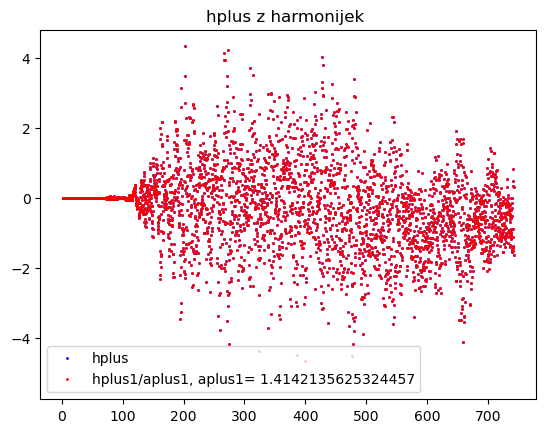

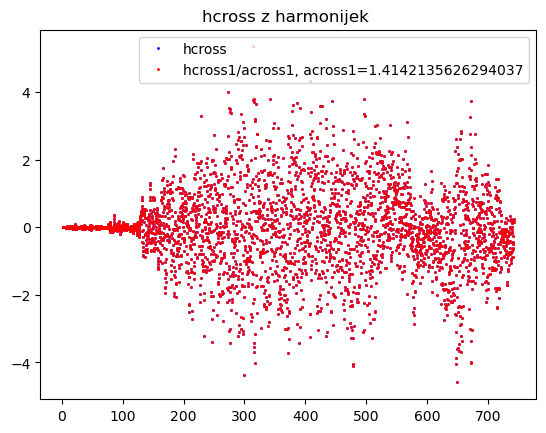

In [12]:
hplus1, hcross1 = NPsolve(RealA22, ImA22, RealA21, ImA21, RealA20, ImA20, RealA2minus1, ImA2minus1, RealA2minus2, ImA2minus2, np.pi/2, 0 )

aplus1, bplus1 = np.polyfit(hplus, hplus1, 1)
across1, bcross1 = np.polyfit(hcross, hcross1, 1)

plt.figure()
plt.plot(czas, hplus, marker='.', linestyle='', color="b", markersize=2, label="hplus")
plt.plot(czas, hplus1/aplus1, marker='.', linestyle='', color="r", markersize=2, label=f"hplus1/aplus1, aplus1= {aplus1}" )
plt.title("hplus z harmonijek ")
plt.legend()

plt.figure()
plt.plot(czas, hcross, marker='.', linestyle='', color="b", markersize=2, label="hcross")
plt.plot(czas, hcross1/across1, marker='.', linestyle='', color="r", markersize=2, label=f"hcross1/across1, across1={across1}")
plt.title("hcross z harmonijek ")
plt.legend()

plt.show

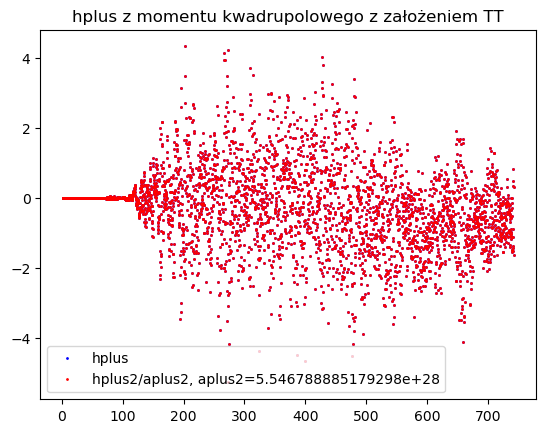

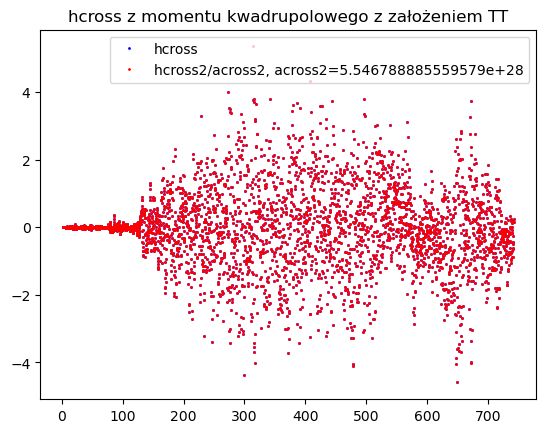

In [13]:
I11, I22, I33, I13, I23, I12 = NPtoquad(RealA22, ImA22, RealA21, ImA21, RealA20, ImA20, RealA2minus1, ImA2minus1, RealA2minus2, ImA2minus2)

hplus2, hcross2 = quadsolve (I11, I22, I33, I13, I23, I12, np.pi/2, 0)

aplus2, bplus2 = np.polyfit(hplus, hplus2, 1)
across2, bcross2 = np.polyfit(hcross, hcross2, 1)

plt.figure()
plt.plot(czas, hplus, marker='.', linestyle='', color="b", markersize=2, label="hplus")
plt.plot(czas, hplus2/aplus2, marker='.', linestyle='', color="r", markersize=2, label=f"hplus2/aplus2, aplus2={aplus2}")
plt.title("hplus z momentu kwadrupolowego z założeniem TT")
plt.legend()

plt.figure()
plt.plot(czas, hcross, marker='.', linestyle='', color="b", markersize=2, label="hcross")
plt.plot(czas, hcross2/across2, marker='.', linestyle='', color="r", markersize=2, label=f"hcross2/across2, across2={across2}")
plt.title("hcross z momentu kwadrupolowego z założeniem TT")
plt.legend()

plt.show()

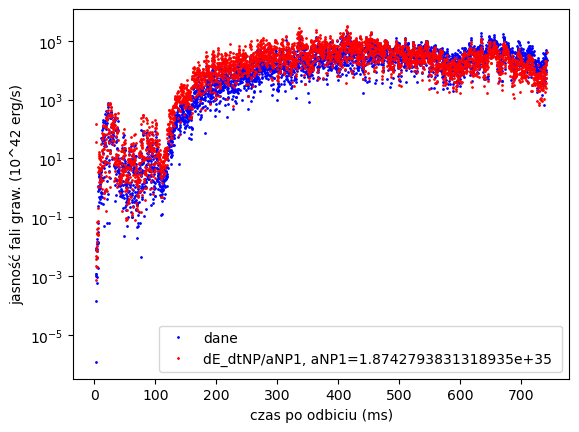

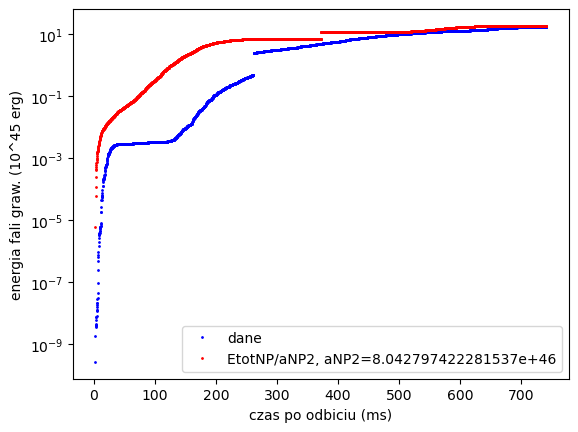

In [14]:
dE_dtNP = dE_dtNP (RealA22, ImA22, RealA21, ImA21, RealA20, ImA20, RealA2minus1, ImA2minus1, RealA2minus2, ImA2minus2, czas)
EtotNP = EtotNP (RealA22, ImA22, RealA21, ImA21, RealA20, ImA20, RealA2minus1, ImA2minus1, RealA2minus2, ImA2minus2, czas)

aNP1, bNP1 = np.polyfit(dEdt, dE_dtNP , 1)
aNP2, bNP2 = np.polyfit(Etot, EtotNP , 1)

plt.figure()
plt.plot(czas, dEdt, marker='.', linestyle='', color="b", markersize=2, label="dane")
plt.plot(czas, dE_dtNP/aNP1, marker='.', linestyle='', color="r", markersize=2, label=f"dE_dtNP/aNP1, aNP1={aNP1} ")
plt.yscale("log")
plt.xlabel("czas po odbiciu (ms)")
plt.ylabel("jasność fali graw. (10^42 erg/s)")
plt.legend()

plt.figure()
plt.plot(czas,Etot , marker='.', linestyle='', color="b", markersize=2, label="dane")
plt.plot(czas,EtotNP/aNP2 , marker='.', linestyle='', color="r", markersize=2, label=f"EtotNP/aNP2, aNP2={aNP2}")
plt.yscale("log")
plt.xlabel("czas po odbiciu (ms)")
plt.ylabel("energia fali graw. (10^45 erg)")
plt.legend()

plt.show()

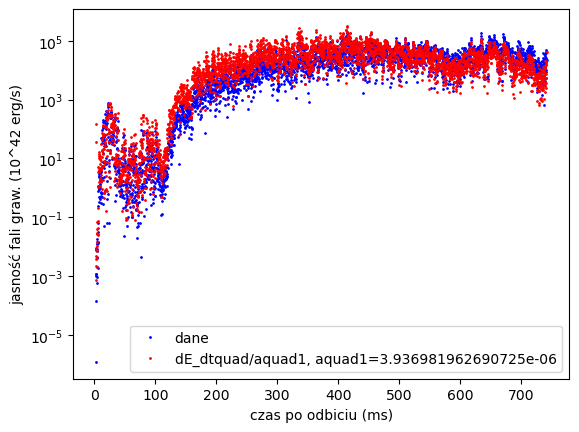

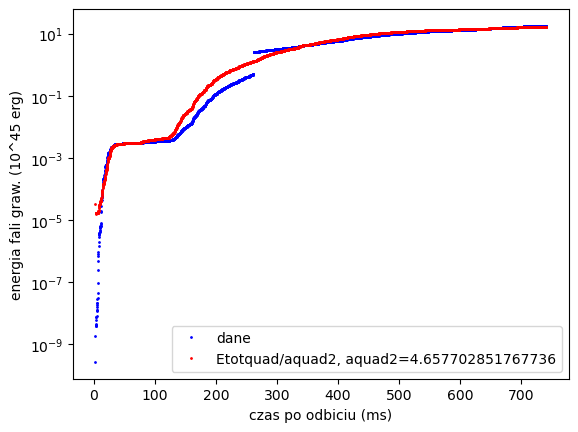

In [15]:
dE_dtquad = dE_dtquad (I11, I22, I33, I13, I23, I12, czas)
Etotquad = Etotquad (I11, I22, I33, I13, I23, I12, czas)

aNP1, bNP1 = np.polyfit(dEdt, dE_dtNP , 1)
aNP2, bNP2 = np.polyfit(Etot, EtotNP , 1)

aquad1, bquad1 = np.polyfit(dEdt, dE_dtquad , 1)
aquad2, bquad2 = np.polyfit(Etot, Etotquad , 1)

plt.figure()
plt.plot(czas, dEdt, marker='.', linestyle='', color="b", markersize=2, label="dane")
plt.plot(czas, dE_dtquad/aquad1, marker='.', linestyle='', color="r", markersize=2, label=f"dE_dtquad/aquad1, aquad1={aquad1}")
plt.yscale("log")
plt.xlabel("czas po odbiciu (ms)")
plt.ylabel("jasność fali graw. (10^42 erg/s)")
plt.legend()

plt.figure()
plt.plot(czas,Etot , marker='.', linestyle='', color="b", markersize=2, label="dane")
plt.plot(czas,Etotquad/aquad2 , marker='.', linestyle='', color="r", markersize=2, label=f"Etotquad/aquad2, aquad2={aquad2}")
plt.yscale("log")
plt.xlabel("czas po odbiciu (ms)")
plt.ylabel("energia fali graw. (10^45 erg)")
plt.legend()

plt.show()